In [1]:
#!/usr/bin/env python
import numpy as np
import time
from datetime import date
import matplotlib.pyplot as plt
import sys


import lkTables
import netCDF4 as nc


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 


In [2]:
lkT= lkTables.scattTables()
print(dir(lkT))
import sdsu_tables as sdsu
freq=60.0
temp=273.15
lwc=0.1
nc=800*1e6
sdsu.microp_set()



['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'asymBB', 'asymG', 'asymR', 'asymS', 'attKaBB', 'attKaG', 'attKaR', 'attKaS', 'attKuBB', 'attKuG', 'attKuR', 'attKuS', 'dmBB', 'dmg', 'dmr', 'dms', 'fh', 'fhBB', 'fhGMI', 'graupRate', 'gwc', 'kextBB', 'kextG', 'kextR', 'kextS', 'precRateBB', 'rainRate', 'rwc', 'salbBB', 'salbG', 'salbR', 'salbS', 'snowRate', 'swc', 'zKaBB', 'zKaG', 'zKaR', 'zKaS', 'zKuBB', 'zKuG', 'zKuR', 'zKuS']


In [3]:
print(dir(sdsu))

['__doc__', '__f2py_numpy_version__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_sdsu_tables_error', 'abh2o', 'abliq', 'absn2', 'absorb_py', 'diecon', 'diecon2', 'emiss', 'emiss2', 'emit', 'emit2', 'gasabsr98', 'microp_set', 'mie_cldw', 'o2abs', 'o2com1', 'q2wkg', 'qv2rh', 'radtran', 'vapor']


In [25]:
import netCDF4 as nc
with nc.Dataset('profiles137/saf137.nc') as f:
    qv=f['hum'][:]
    temp=f['temp'][:]
    dz=f['dz'][:]
    p=f['pap'][:]
    rain=f['rain'][:]*3600 # convert from kg/m^2/s to mm/h
    snow=f['snow'][:]*3600 # convert from kg/m^2/s to mm/h
rho=p/(287.05*temp)
print(qv.shape)

(5000, 110)


In [29]:
for nc in [200*1e6]:
    for lwc in [0.1,0.2,0.5,1.0]:
        ksca,asca,gsca,pbck = sdsu.mie_cldw(freq,temp,lwc,nc)

In [37]:
flines=open('freqTable','r').readlines()
freqs=[]
p_m='±'
for l in flines:
    lsplit=l.split()[1:]
    #print(lsplit[0],lsplit[1])
    if lsplit[1]==p_m:
        freqs.append(float(lsplit[0])+float(lsplit[2]))
        #freqs.append(float(lsplit[0])-float(lsplit[2]))
    else:
        freqs.append(float(lsplit[0]))

print(freqs)

[50.3, 51.76, 52.8, 53.711, 54.4, 54.94, 55.5, 57.290344, 88.2, 165.5, 190.31, 187.81, 186.31, 185.11, 184.31]


In [39]:

ifreq,iprof=0,10 # choose a frequency and a profile number
freq=freqs[ifreq]
nlyr=80

kext1D=np.zeros(nlyr)
asym1D=np.zeros(nlyr)
salb1D=np.zeros(nlyr)
fisot=2.7 # background radiation in K
emis=0.9 # surface emissivity at the incidence angle
ebar=0.9 # average surface emissivity 
incAngle=53.0 # incidence angle in degrees
umu=np.cos(incAngle/180*np.pi)

tb_all_profs=[]
tpwL=[]         
for iprof in range(temp.shape[0]):
    tbL=[]
    tpw1=0
    for ifreq,freq in enumerate(freqs):
        btemp=temp[iprof,-1]
        lyrtemp=[temp[iprof,-1]]
        freq=freqs[ifreq]
        kext1D=np.zeros(nlyr)
        asym1D=np.zeros(nlyr)
        salb1D=np.zeros(nlyr)
        fisot=2.7
        hL=[0]
    
        for k in range(nlyr):
            nk=-1-k
            ireturn=0
            absair,abswv = sdsu.gasabsr98(freq,temp[iprof,nk],qv[iprof,nk]*rho[iprof,nk],p[iprof,nk],ireturn)
            hL.append(hL[-1]+dz[iprof,nk])
            if ifreq==0:
                tpw1+=qv[iprof,nk]*rho[iprof,nk]*dz[iprof,nk]
            lyrtemp.append(0.5*(temp[iprof,nk]+temp[iprof,nk-1]))
        
            kext1D[k]=absair+abswv
            asym1D[k]=0
            salb1D[k]=0
        lyrtemp=np.array(lyrtemp)
        lyrhgt=np.array(hL)/1e3 # convert to km
        ilambert=0
        tb=sdsu.radtran(umu,nlyr,btemp,lyrtemp,lyrhgt,kext1D,salb1D,asym1D,fisot,emis,ebar,ilambert)
        tbL.append(tb)
    tb_all_profs.append(tbL)
    tpwL.append(tpw1)



In [40]:
import xarray as xr

tb_xr=xr.DataArray(np.array(tb_all_profs),dims=['prof','freq'],coords={'prof':range(temp.shape[0]),'freq':freqs})
tpw_xr=xr.DataArray(np.array(tpwL),dims=['prof'],coords={'prof':range(temp.shape[0])})
compres={'zlib':True,'complevel':5}
encoding={'tb':compres,'tpw':compres}
ds=xr.Dataset({'tb':tb_xr,'tpw':tpw_xr})
ds.to_netcdf('tb_all_profs.nc',encoding=encoding)

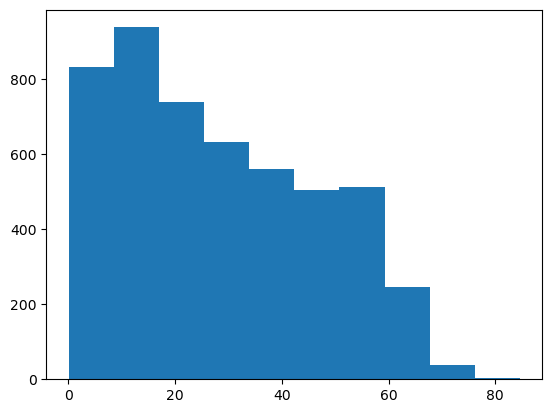

In [42]:
#h1=plt.hist(tpwL)

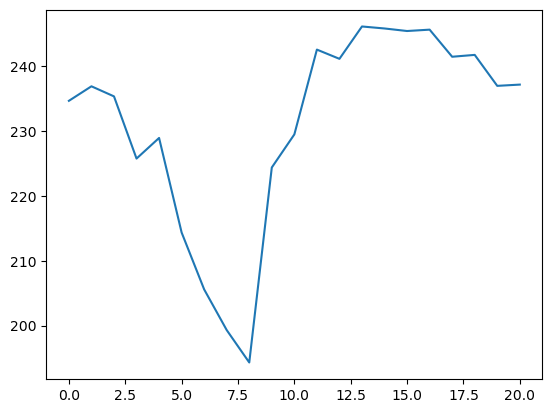

In [35]:
plt.plot(tbL)

In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X=np.array(tb_all_profs)
X_scaled=StandardScaler().fit_transform(X)
y=np.array(tpwL)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)
knn=KNeighborsRegressor(n_neighbors=10,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

[[1.         0.96678802]
 [0.96678802 1.        ]]


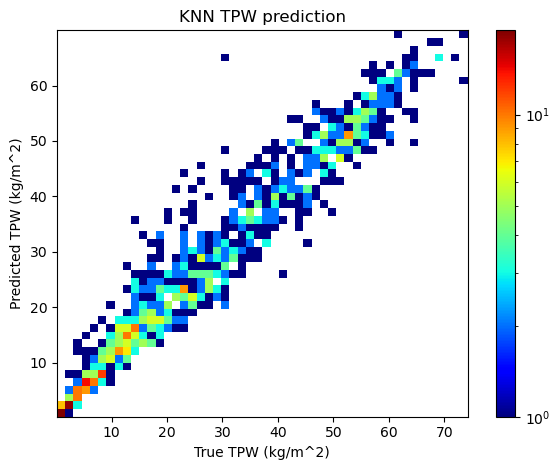

In [52]:
print(np.corrcoef(y_test,y_pred))
import matplotlib.colors as mcolors
ax=plt.subplot(111)
h2d=plt.hist2d(y_test,y_pred,bins=50,norm=mcolors.LogNorm(),cmap='jet')
ax.set_aspect('equal')
plt.colorbar(h2d[3])
plt.xlabel('True TPW (kg/m^2)')
plt.ylabel('Predicted TPW (kg/m^2)')
plt.title('KNN TPW prediction')
plt.tight_layout()
#plt.show()
plt.savefig('knn_tpw.png',dpi=300)